In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import os 
import glob


# Create a custom color map from white to black
white_black_cmap = LinearSegmentedColormap.from_list('white_black', ['white', 'black'], N=256)


In [2]:
def merge_seeds(file_name_pattern='CUB_results_s*_hessian_exact.csv', data_dir='./logs/ISR_Hessian_results_new'):
    # Create the full pattern for glob
    full_pattern = os.path.join(data_dir, file_name_pattern)

    # Use glob to get all file paths matching the pattern
    all_files = glob.glob(full_pattern)

    # Initialize an empty list to hold the dataframes
    df_list = []

    # Loop through the files, read each into a dataframe, and append it to the list
    for file_path in all_files:
        df = pd.read_csv(file_path)
        df['gradient_alpha'] = df['gradient_alpha'].astype(float).round(8)
        df['hessian_beta'] = df['hessian_beta'].astype(float).round(8)
        df_list.append(df)

    # Concatenate all the dataframes in the list
    merged_df = pd.concat(df_list, ignore_index=True)
    merged_df.drop(0, inplace=True)
    merged_df['gradient_alpha'] = pd.to_numeric(merged_df['gradient_alpha'], errors='coerce')
    merged_df['hessian_beta'] = pd.to_numeric(merged_df['hessian_beta'], errors='coerce')
    merged_df['penalty_anneal_iters'] = pd.to_numeric(merged_df['penalty_anneal_iters'], errors='coerce')
    # Define columns for the groupby operation based on 'fishr' in filename

    if 'fishr' in file_name_pattern:
        group_columns = ['dataset', 'split', 'method', 'ISR_class', 'ISR_scale', 'num_iter', 'ema', 'lambda',
                         'penalty_anneal_iters']
    elif 'coral' in file_name_pattern:
        group_columns = ['dataset', 'split', 'method', 'ISR_class', 'ISR_scale', 'num_iter', 'mmd_gamma']
    else:
        group_columns = ['dataset', 'split', 'method', 'ISR_class', 'ISR_scale', 'num_iter', 'gradient_alpha',
                     'hessian_beta', 'penalty_anneal_iters']
    # Add 'num_runs' before groupby
    merged_df['num_runs'] = merged_df.groupby(group_columns).transform('size')
    # merged_df['seed_runs'] = merged_df.groupby(group_columns)['seed'].transform(lambda x: list(x.unique()))
    seed_runs = merged_df.groupby(group_columns)['seed'].agg(lambda x: list(set(x))).rename('seed_runs')

    # Merge this aggregated data back to the original DataFrame if needed
    merged_df = merged_df.merge(seed_runs, on=group_columns, how='left')

    # Group and aggregate data

    merged_df['num_iter'] = pd.to_numeric(merged_df['num_iter'], errors='coerce')


    # base_columns = ['dataset', 'seed', 'split', 'method', 'ISR_class', 'ISR_scale', 'num_iter', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc','num_runs','seed_runs']
    if 'fishr' in file_name_pattern:
        merged_df = merged_df[['dataset','seed','split','method','ISR_class','ISR_scale','num_iter', 'ema','lambda','penalty_anneal_iters', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc','num_runs','seed_runs']]

    elif 'coral' in file_name_pattern:
        merged_df = merged_df[['dataset','seed','split','method','ISR_class','ISR_scale','num_iter', 'mmd_gamma', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc','num_runs','seed_runs']]
    else:
        merged_df = merged_df[['dataset','seed','split','method','ISR_class','ISR_scale','num_iter', 'gradient_alpha', 'hessian_beta','penalty_anneal_iters', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc','num_runs','seed_runs']]


    if 'CUB' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==300]
    elif 'CelebA' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==50]
    elif 'MultiNLI' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==3]
    # if 'fishr' in file_name_pattern:
    #     grouped = merged_df.groupby(['dataset', 'split', 'method', 'ISR_class', 'ISR_scale',
    #                                  'num_iter','ema','lambda','penalty_anneal_iters']).agg({
    #         'avg_acc': ['mean', 'sem'],
    #         'worst_acc': ['mean', 'sem']
    #     })
    # else:
    #     merged_df.fillna(0, inplace=True)
    #     grouped = merged_df.groupby(['dataset', 'split', 'method', 'ISR_class', 'ISR_scale',
    #                             'num_iter', 'gradient_alpha', 'hessian_beta','penalty_anneal_iters']).agg({
    #         'avg_acc': ['mean', 'sem'],
    #         'worst_acc': ['mean', 'sem']
    #     })

    merged_df['avg_acc'] = pd.to_numeric(merged_df['avg_acc'], errors='coerce')
    merged_df['worst_acc'] = pd.to_numeric(merged_df['worst_acc'], errors='coerce')
    grouped = merged_df.groupby(group_columns).agg({
        'avg_acc': ['mean', 'sem'],
        'worst_acc': ['mean', 'sem'],
        'num_runs': 'first',
        'seed_runs': 'first'
    })

    import numpy as np
    # manually check for sem
    grouped2 = merged_df.groupby(group_columns).agg({
        'avg_acc': ['mean', lambda x: x.std(ddof=1) / np.sqrt(len(x))],
        'worst_acc': ['mean', lambda x: x.std(ddof=1) / np.sqrt(len(x))],
        'num_runs': 'first',
        'seed_runs': 'first'
    })


    # Renaming the columns for clarity
    grouped.columns = ['avg_acc_mean', 'avg_acc_sem', 'worst_acc_mean', 'worst_acc_sem', 'num_runs','seed_runs']
    grouped2.columns = ['avg_acc_mean', 'avg_acc_sem', 'worst_acc_mean', 'worst_acc_sem', 'num_runs','seed_runs']
    # Resetting the index if you want the grouped columns back as regular columns
    grouped = grouped.reset_index()
    grouped2 = grouped2.reset_index()

    # cleaned_grouped = grouped.dropna(subset=['avg_acc_sem', 'worst_acc_sem'])
    cleaned_grouped = grouped
    # Display the cleaned DataFrame
    # print(cleaned_grouped)
    val = cleaned_grouped[cleaned_grouped['split'] == 'val']
    test = cleaned_grouped[cleaned_grouped['split'] == 'test']
    num_runs = len(all_files)
    dataset = file_name_pattern.split('_')[0]
    if 'fishr' in file_name_pattern:
        val.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_fishr_val.csv', index=False)
        test.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_fishr_test.csv', index=False)
    elif 'coral' in file_name_pattern:
        val.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_coral_val.csv', index=False)
        test.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_coral_test.csv', index=False)
    else:
        val.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_val.csv', index=False)
        test.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_test.csv', index=False)
    # print(f"Saved {dataset}_{num_runs}runs_val.csv and {dataset}_{num_runs}runs_test.csv in {data_dir}")
    return val, test

In [550]:
data_dir = './logs/ISR_result_bias'

merge_seeds(file_name_pattern='CUB_results_s*_hessian_exact.csv', data_dir = data_dir)
merge_seeds(file_name_pattern='CelebA_results_s*_hessian_exact.csv', data_dir = data_dir)
merge_seeds(file_name_pattern='MultiNLI_results_s*_hessian_exact.csv', data_dir = data_dir)



(    dataset split           method  ISR_class  ISR_scale  num_iter  \
 3  MultiNLI   val  HISR-exact-Mean        2.0        0.0       3.0   
 4  MultiNLI   val  HISR-exact-Mean        2.0        0.0       3.0   
 5  MultiNLI   val  HISR-exact-Mean        2.0        0.0       3.0   
 
    gradient_alpha  hessian_beta  penalty_anneal_iters  avg_acc_mean  \
 3             0.0           0.0                   0.0      0.813229   
 4          2000.0         100.0                   0.0      0.717341   
 5          5000.0           1.0                   0.0      0.811841   
 
    avg_acc_sem  worst_acc_mean  worst_acc_sem  num_runs  \
 3     0.003079        0.685383       0.003295         4   
 4     0.094658        0.552894       0.132213         5   
 5     0.003372        0.685312       0.004782         5   
 
                    seed_runs  
 3       [0.0, 1.0, 2.0, 4.0]  
 4  [0.0, 1.0, 2.0, 3.0, 4.0]  
 5  [0.0, 1.0, 2.0, 3.0, 4.0]  ,
     dataset split           method  ISR_class  ISR_s

In [551]:

# Example DataFrame
cub_file = 'CUB_5runs_val.csv'
celeba_file = 'CelebA_5runs_val.csv'
multinli_file = 'MultiNLI_5runs_val.csv'

cub_file_fishr = 'CUB_5runs_fishr_val.csv'
celeba_file_fishr = 'CelebA_5runs_fishr_val.csv'
multinli_file_fishr = 'MultiNLI_5runs_fishr_val.csv'

cub_file_coral = 'CUB_5runs_coral_val.csv'
celeba_file_coral = 'CelebA_5runs_coral_val.csv'
multinli_file_coral = 'MultiNLI_5runs_coral_val.csv'


# df = pd.read_csv(os.path.join('./logs/ISR_Hessian_results_new', cub_file))
df = pd.read_csv(os.path.join(data_dir, celeba_file))
# df = pd.read_csv(os.path.join('./logs/ISR_Hessian_results_new', multinli_file))



if df['dataset'].iloc[0] == 'CUB':
    acc_min, acc_max = 0.8, 0.9
elif df['dataset'].iloc[0] == 'CelebA':
    acc_min, acc_max = 0.5, 0.70
elif df['dataset'].iloc[0] == 'MultiNLI':
    acc_min, acc_max = 0.5, 0.7
# Creating a pivot table, averaging over 'penalty_anneal_iters'
pivot_df = df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')

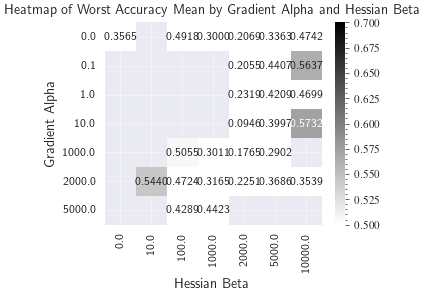

In [552]:
sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
plt.title('Heatmap of Worst Accuracy Mean by Gradient Alpha and Hessian Beta')
plt.xlabel('Hessian Beta')
plt.ylabel('Gradient Alpha')
plt.show()

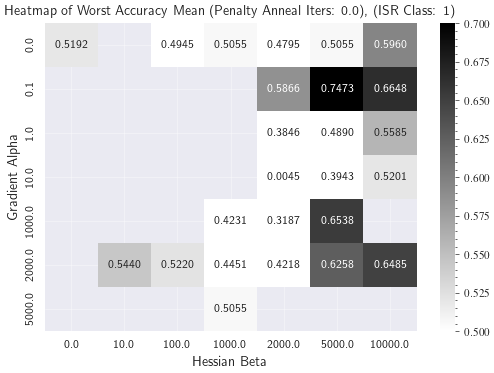

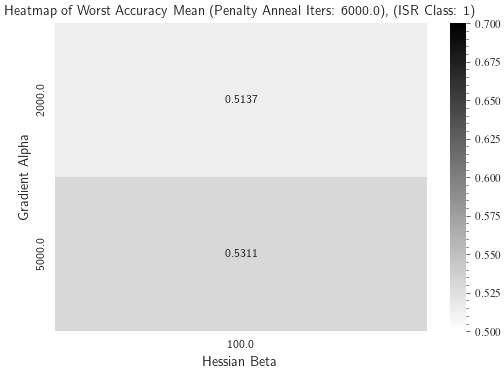

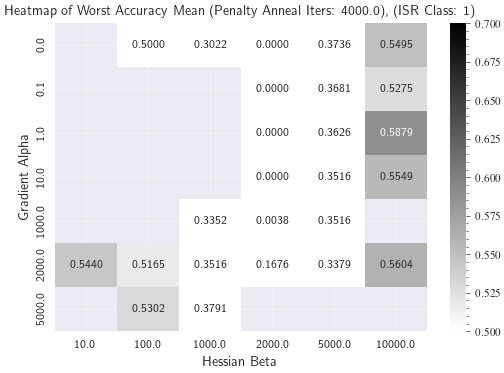

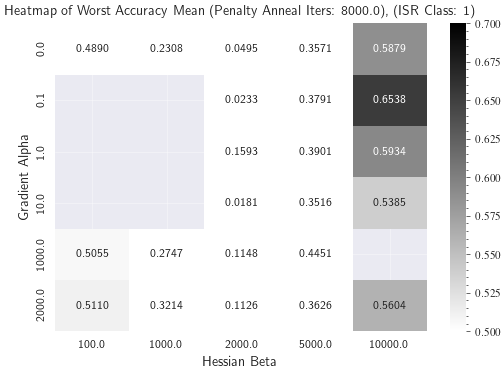

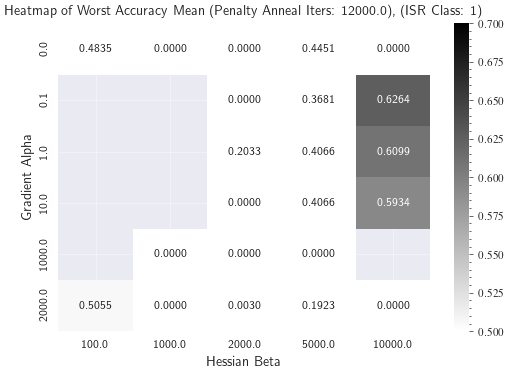

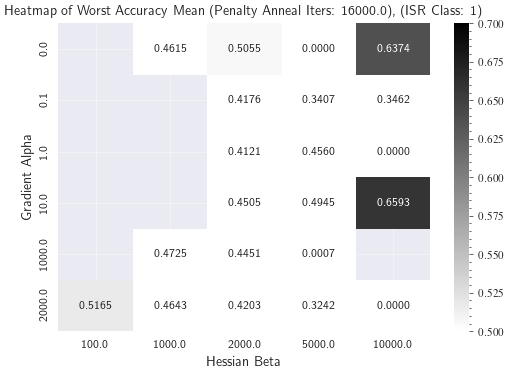

In [553]:
# We can create multiple heatmaps for each unique pairs value of 'ISR_class'and 'penalty_anneal_iters'
from itertools import product
df = df[df['hessian_beta'] <= 10000]
unique_iters = product(df['penalty_anneal_iters'].unique(), df['ISR_class'].unique())
# unique_iters = df['penalty_anneal_iters'].unique()

# for iters, isr_class in unique_iters:
for iters, isr_class in product(df['penalty_anneal_iters'].unique(), [1]):
    sub_df = df[df['penalty_anneal_iters'] == iters]
    sub_df = sub_df[sub_df['ISR_class'] == isr_class]
    pivot_df = sub_df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
    plt.title(f'Heatmap of Worst Accuracy Mean (Penalty Anneal Iters: {iters}), (ISR Class: {isr_class})')
    plt.xlabel('Hessian Beta')
    plt.ylabel('Gradient Alpha')
    plt.show()


In [554]:
df = pd.read_csv(os.path.join('./logs/ISR_Hessian_results_new', multinli_file_fishr))
df

,dataset,split,method,ISR_class,ISR_scale,num_iter,ema,lambda,penalty_anneal_iters,avg_acc_mean,avg_acc_sem,worst_acc_mean,worst_acc_sem,num_runs,seed_runs
0,MultiNLI,val,Fishr-Mean,0,0,3,0.90,10.0,0.0,0.822063,NaN,0.648683,NaN,1,[0]
1,MultiNLI,val,Fishr-Mean,0,0,3,0.90,10.0,300.0,0.823373,NaN,0.658720,NaN,1,[0]
2,MultiNLI,val,Fishr-Mean,0,0,3,0.90,10.0,600.0,0.824355,NaN,0.668758,NaN,1,[0]
3,MultiNLI,val,Fishr-Mean,0,0,3,0.90,100.0,0.0,0.825192,NaN,0.652447,NaN,1,[0]
4,MultiNLI,val,Fishr-Mean,0,0,3,0.90,100.0,300.0,0.825423,NaN,0.671267,NaN,1,[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,MultiNLI,val,Fishr-Mean,2,0,3,0.99,1000.0,900.0,0.824234,NaN,0.691343,NaN,1,[0]
234,MultiNLI,val,Fishr-Mean,2,0,3,0.99,10000.0,0.0,0.823458,NaN,0.677541,NaN,1,[0]
235,MultiNLI,val,Fishr-Mean,2,0,3,0.99,10000.0,300.0,0.809985,NaN,0.644372,NaN,1,[0]
236,MultiNLI,val,Fishr-Mean,2,0,3,0.99,10000.0,600.0,0.813182,0.001927,0.711034,0.012844,5,"[0, 1, 2, 3, 4]"


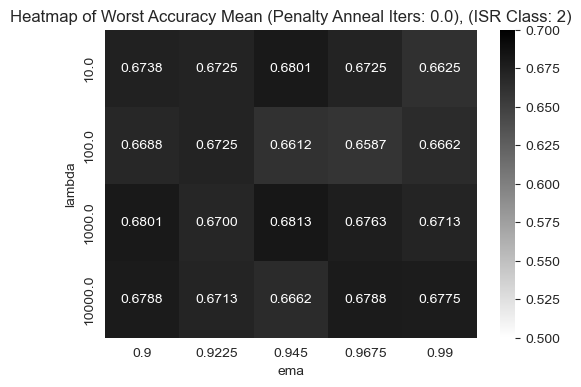

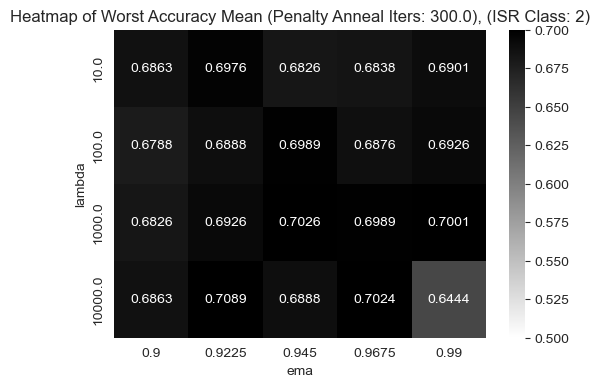

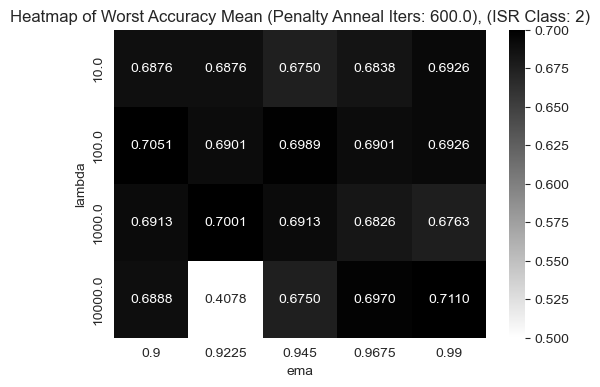

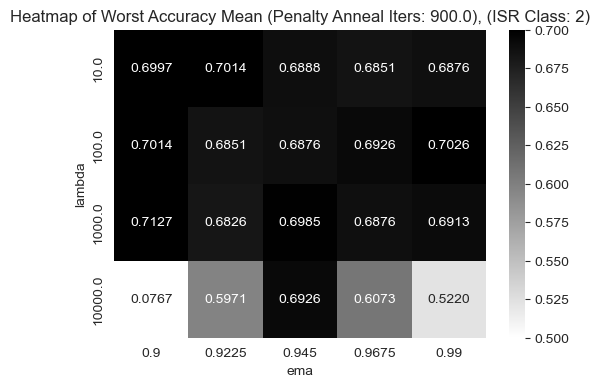

In [235]:
# We can create multiple heatmaps for each unique pairs value of 'ISR_class'and 'penalty_anneal_iters'
from itertools import product
unique_iters = product(df['penalty_anneal_iters'].unique(), df['lambda'].unique())
# unique_iters = df['penalty_anneal_iters'].unique()

# for iters, isr_class in unique_iters:
for iters, isr_class in product(df['penalty_anneal_iters'].unique(), [2]):
    sub_df = df[df['penalty_anneal_iters'] == iters]
    sub_df = sub_df[sub_df['ISR_class'] == isr_class]
    pivot_df = sub_df.pivot_table(values='worst_acc_mean', index='lambda', columns='ema', aggfunc='mean')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
    plt.title(f'Heatmap of Worst Accuracy Mean (Penalty Anneal Iters: {iters}), (ISR Class: {isr_class})')
    plt.xlabel('ema')
    plt.ylabel('lambda')
    plt.show()


In [530]:
# progress_dir = './logs/ISR_training_progress'
progress_dir = './logs/ISR_Hessian_for_plotting'
dataset = 'CelebA'
# dataset = 'CUB'
# steps_per_epoch = 10
steps_per_epoch = 325
seed_list = [0,1,2,3,4]
ISR_class = 0
grad_alpha = 5000
# grad_alpha = 10
hess_beta = 100
# hess_beta = 1000
penalty_anneal_iters = 4000
# penalty_anneal_iters = 2100
grad_alpha_formatted = "{:.1e}".format(grad_alpha).replace('.0e', 'e')
hess_beta_formatted = "{:.1e}".format(hess_beta).replace('.0e', 'e')
dfs = []
dfs_val = []
for seed in seed_list:
    progress_file_dir = f"ISRclass_{ISR_class}_grad_alpha_{grad_alpha_formatted}_hess_beta_{hess_beta_formatted}_anneal_{penalty_anneal_iters}.0"
    if not os.path.exists(os.path.join(progress_dir, dataset, f's{seed}', progress_file_dir)):
        progress_file_dir = f"ISRclass_{ISR_class}_grad_alpha_{grad_alpha_formatted}_hess_beta_{hess_beta_formatted}_anneal_{penalty_anneal_iters}"
    df_train = pd.read_csv(os.path.join(progress_dir, dataset, f's{seed}', progress_file_dir, 'train.csv'))
    df_val = pd.read_csv(os.path.join(progress_dir, dataset, f's{seed}', progress_file_dir, 'train.csv'))
    dfs.append(df_train)
    dfs_val.append(df_val)
    
merged_df = pd.concat(dfs, ignore_index=True)
merged_df_val = pd.concat(dfs_val, ignore_index=True)
#compute the average and standard deviation of the accuracy, loss, and penalties across the runs
merged_df['hessian_loss'] = merged_df['hessian_loss'] * hess_beta
grouped = merged_df.groupby(['epoch']).agg({
    'total_loss': ['mean', 'sem'],
    'erm_loss': ['mean', 'sem'],
    'grad_loss': ['mean', 'sem'],
    'hessian_loss': ['mean', 'sem'],
    'avg_acc': ['mean', 'sem'],
    'worst_acc': ['mean', 'sem']
})
grouped_val = merged_df_val.groupby(['epoch']).agg({
    'total_loss': ['mean', 'sem'],
    'erm_loss': ['mean', 'sem'],
    'grad_loss': ['mean', 'sem'],
    'hessian_loss': ['mean', 'sem'],
    'avg_acc': ['mean', 'sem'],
    'worst_acc': ['mean', 'sem']
})
grouped.columns = ['total_loss_mean', 'total_loss_std', 'erm_loss_mean', 'erm_loss_std', 'grad_loss_mean', 'grad_loss_std', 'hessian_loss_mean', 'hessian_loss_std', 'avg_acc_mean', 'avg_acc_std', 'worst_acc_mean', 'worst_acc_std']

grouped_val.columns = ['total_loss_mean', 'total_loss_std', 'erm_loss_mean', 'erm_loss_std', 'grad_loss_mean', 'grad_loss_std', 'hessian_loss_mean', 'hessian_loss_std', 'avg_acc_mean', 'avg_acc_std', 'worst_acc_mean', 'worst_acc_std']

# steps_per_epoch = 325
# steps_per_epoch = 10
epoch_for_step = penalty_anneal_iters/ steps_per_epoch

# progress_file_dir = f"ISRclass_{ISR_class}_grad_alpha_{grad_alpha_formatted}_hess_beta_{hess_beta_formatted}_anneal_{penalty_anneal_iters}.0"
# df8000 = pd.read_csv(os.path.join(progress_dir, dataset, f's{seed}', progress_file_dir, 'train.csv'))

In [531]:
grouped['hessian_loss_std']

epoch
0     0.002646
1     0.001802
2     0.001719
3     0.001714
4     0.001663
5     0.001661
6     0.001676
7     0.001587
8     0.001603
9     0.001635
10    0.001617
11    0.001604
12    0.004024
13    0.001019
14    0.000911
15    0.000843
16    0.000839
17    0.000813
18    0.000793
19    0.000815
20    0.000773
21    0.000766
22    0.000780
23    0.000769
24    0.000784
25    0.000746
26    0.000765
27    0.000776
28    0.000754
29    0.000745
30    0.000751
31    0.000739
32    0.000772
33    0.000765
34    0.000763
35    0.000730
36    0.000727
37    0.000764
38    0.000748
39    0.000737
40    0.000738
41    0.000752
42    0.000719
43    0.000738
44    0.000754
45    0.000729
46    0.000743
47    0.000729
48    0.000739
49    0.000728
Name: hessian_loss_std, dtype: float64

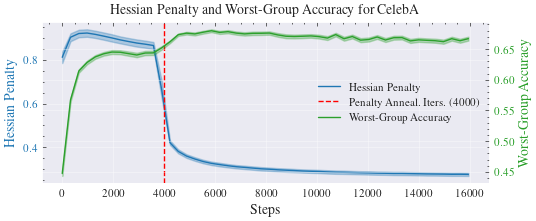

In [534]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from mpl_sizes import get_format

formatter = get_format("NeurIPS") # options: ICLR, ICML, NeurIPS, InfThesis

# fig, ax = plt.subplots(figsize=formatter.text_width_plot())


# plt.style.use('science')

# Constants
# steps_per_epoch = 325
# steps_per_epoch = 10  # Uncomment this line if using a different steps_per_epoch value
epoch_for_step = penalty_anneal_iters / steps_per_epoch

# Convert epoch to steps for plotting
grouped['steps'] = grouped.index * steps_per_epoch
# grouped_val['steps'] = grouped_val['epoch'] * steps_per_epoch  # Uncomment if using validation data

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=formatter.text_width_plot())
plt.rcParams.update({'grid.alpha': 0.5})

# Plot Hessian Loss on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Steps')
# ax1.set_ylabel(r'$\frac{\beta}{K}\sum_{i \in [K]} \|\mathbf{H}_{\mu_i}(\theta) - \overline{\mathbf{H}(\theta)}\|^2_F$', color=color)
ax1.set_ylabel('Hessian Penalty', color=color)
sns.lineplot(data=grouped, x='steps', y='hessian_loss_mean', ax=ax1, label='Hessian Penalty', color=color)
plt.fill_between(grouped['steps'], grouped['hessian_loss_mean'] - grouped['hessian_loss_std'], grouped['hessian_loss_mean'] + grouped['hessian_loss_std'], alpha=0.3, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Add a vertical line at penalty_anneal_iters
ax1.axvline(x=penalty_anneal_iters, color='red', linestyle='--', label=f'Penalty Anneal. Iters. ({penalty_anneal_iters})')

# Create a secondary y-axis to plot worst-group accuracy
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Worst-Group Accuracy', color=color)
sns.lineplot(data=grouped, x='steps', y='worst_acc_mean', ax=ax2, label='Worst-Group Accuracy', color=color, legend=False)
plt.fill_between(grouped['steps'], grouped['worst_acc_mean'] - grouped['worst_acc_std'], grouped['worst_acc_mean'] + grouped['worst_acc_std'], alpha=0.3, color=color)
ax2.tick_params(axis='y', labelcolor=color)


# Add a title and show the plot
plt.title(f'Hessian Penalty and Worst-Group Accuracy for {dataset}')
fig.tight_layout()  # Adjust layout to prevent clipping

# Manually create legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine the legends and set them
ax1.legend(lines + lines2, labels + labels2, loc='center right')
# plt.savefig('./logs/ISR_Hessian_for_plotting/fig_hess'
#             '_acc.svg',format = 'svg')
# plt.savefig('./logs/ISR_Hessian_for_plotting/fig_hess'
#             '_acc.pdf',format = 'pdf')
plt.show()


In [526]:
new_dir = './logs/ISR_Hessian_results_new'

file_patterns = ['CelebA_results_s*_hessian_exact.csv', 'CUB_results_s*_hessian_exact.csv', 'MultiNLI_results_s*_hessian_exact.csv']

file_list = []
for file_pattern in file_patterns:
    file_list.extend(glob.glob(os.path.join(new_dir, file_pattern)))

for file_pattern in file_list:
    df_new = pd.read_csv(file_pattern)
    # round gradient_alpha and hessian_beta to 8 decimal places
    df_new['gradient_alpha'] = df_new['gradient_alpha'].round(8)
    df_new['hessian_beta'] = df_new['hessian_beta'].round(8)

In [256]:
file_list[-1]

'./logs/ISR_Hessian_results_new/MultiNLI_results_s0_hessian_exact.csv'

In [260]:
df_new = pd.read_csv(file_list[-1])


In [263]:
df_new['hessian_beta'] = df_new['hessian_beta'].round(8)

In [264]:
df_new.to_csv(file_list[-1], index=False)